In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def results_plot_maker(ax, yvals, xvals, xlabel, ylabel, title, colors,
                       LABEL_FONTSIZE, TITLE_FONTSIZE, TICK_FONTSIZE,
                       use_fill_between=True,
                       fix_ticklabels=False,
                       model_top=None,
                       model_medium=None,
                       model_bottom=None, 
                       reverse=False, 
                       legend_labels=None):
    # here we assume we're plotting to a matplotlib axis object
    # and yvals is a LIST of arrays of size (n_runs, iterations),
    # where each can be different sized
    # and if xvals is given then len(xvals) == len(yvals)

    # set the labelling
    
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    # ax.set_title(title, fontsize=TITLE_FONTSIZE)
    
    if legend_labels is None:
        labels = [None for i in range(len(colors))]
        zipper = zip(colors, xvals, yvals, labels)
    else:
        zipper = zip(colors, xvals, yvals, legend_labels)

    for color, x, Y, label in zipper:
        
        if reverse:
            Y = -Y
        bot, mid, top = [_.ravel() for _ in
                         np.percentile(Y, [25, 50, 75], axis=0)]
        if use_fill_between:
            ax.fill_between(x, bot.flat, top.flat, color=color, alpha=0.15)

        ax.plot(x, mid, color=color, label=label)
        ax.plot(x, bot, '--', color=color, alpha=0.15)
        ax.plot(x, top, '--', color=color, alpha=0.15)

    if model_top is not None:
        if use_fill_between:
            ax.fill_between(x, model_bottom.flat, model_top.flat, color=color, alpha=0.15)
        for x in xvals:
            ax.plot(x, model_top, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_bottom, '--', color=[158, 218, 229], alpha=0.15)
            ax.plot(x, model_medium, color=[158, 218, 229])

    # set the xlim
    min_x = np.min([np.min(x) for x in xvals])
    max_x = np.max([np.max(x) for x in xvals])
    ax.set_xlim([0, max_x + 1])

    ax.axvline(min_x, linestyle='dashed', color='gray', linewidth=1, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

    # set the alignment for outer ticklabels
    ax.set_xticks([0, 25, 50, 75, 100])
    if fix_ticklabels:
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")
    ax.legend()
    
    
model_list = [
    'BO',
    'BO_noise',
    'LinearBO',
    'LinearBO_noise',
    'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]


tablau20 = np.array([
    [ 31, 119, 180], [255, 127,  14], [ 44, 160,  44], [214,  39,  40],
    [148, 103, 189], [140,  86,  75], [227, 119, 194], [127, 127, 127],
    [188, 189,  34], [ 23, 190, 207], [174, 199, 232], [255, 187, 120],
    [152, 223, 138], [255, 152, 150], [197, 176, 213], [196, 156, 148],
    [247, 182, 210], [199, 199, 199], [219, 219, 141], [158, 218, 229]
]) / 255.

mean_cols = tablau20[:len(model_list)]  # color bar

LABEL_FONTSIZE = 20
TITLE_FONTSIZE = 20
TICK_FONTSIZE = 15

def save_result_image(result_daraframes, result_daraframes_1, save_name):
    x_vals = []
    lengths = [result_dataframe.shape[1] for result_dataframe in result_daraframes]
    for i in range(len(result_daraframes)):
        x = np.arange(0, min(lengths), 1)
        x_vals.append(x)
        result_daraframes[i] = result_daraframes[i].iloc[:, :min(lengths)]
        
    fig, a = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)
    results_plot_maker(a[0], result_daraframes, x_vals, 'Iteration', save_name, 'Optimization result', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, reverse=False, legend_labels=model_list)
    results_plot_maker(a[1], result_daraframes_1, x_vals, 'Iteration', None, 'Simple regret', mean_cols, LABEL_FONTSIZE, TITLE_FONTSIZE,
                       TICK_FONTSIZE, legend_labels=model_list)
    # plt.legend()
    plt.savefig(save_name+'.pdf', format='pdf')


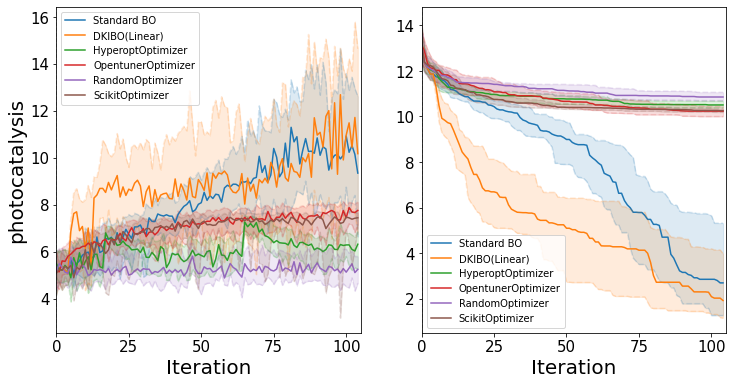

In [22]:
# plotting photocatalysis experiment
# 催化剂实验图生成
# todo: 增加EABO(rf)的图

import os


problem_name = 'photocatalysis_experiment'

base_path = r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_same_seed'

model_list = [
    'BO',
    # 'BO_noise',
    # 'LinearBO',
    # 'LinearBO_noise',
    # 'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]

result_dfs = []
for i in model_list:
    if 'noise' not in i:
        result_dfs.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}.csv'.format(i, problem_name)), index_col=0))
    else:
        result_dfs.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}_noise.csv'.format(i.strip('_noise'), problem_name)), index_col=0))

# Change label names
model_list = [
    'Standard BO',
    'DKIBO(Linear)',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]
        
def show_pic(result_dfs):
    # result_daraframes.append(contrast_result_dataframe)
    
    def transform_to_regret(dfs):
        maximum = 0
        for df in dfs:
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in dfs:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs
    result_daraframes_regret = transform_to_regret(result_dfs)
    save_result_image(result_dfs, result_daraframes_regret, 'photocatalysis')
    
show_pic(result_dfs)

In [21]:
import os


model_list = [
    'BO',
    'BO_noise',
    # 'LinearBO',
    # 'LinearBO_noise',
    # 'LinearBOEarlyStop',
    # 'LinearBOEarlyStop_noise',
    'RFBO',
    'RFBO_noise',
    'RFBOEarlyStop',
    'RFBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]

test_problems = [
    'Ackley',
    'Branin',
    'Eggholder',
    'GoldsteinPrice',
    'SixHumpCamel',
    'Shekel',
    'Hartmann6',
    'Michalewicz',
    'Rosenbrock',
    'StyblinskiTang',
]

base_dir = r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_same_seed'

def read_data(model_list, test_problems):
    dfs = {}
    for problem_name in test_problems:
        df_list = []
        for model_name in model_list:
            if 'noise' not in model_name:
                df_list.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}.csv'.format(model_name, problem_name)), index_col=0))
            else:
                df_list.append(pd.read_csv(os.path.join(base_path, '{}_result_test_{}_noise.csv'.format(model_name.strip('_noise'), problem_name)), index_col=0))

        dfs[problem_name] = df_list
    return dfs


In [19]:
# get result analysis for synthetic experiment

dfs = read_data(model_list, test_problems)

def get_result_dicts(result_dfs, model_list):
    
    result_dicts = []
    def transform_to_regret(df_s):
        maximum = -10000
        for df in df_s:
            # print(type(df))
            maximum = max(maximum, df.max().max())
        new_dfs = []
        for df in df_s:
            df = maximum - df
            for i in range(len(df)):
                for j in range(len(df.iloc[i])):
                    if j > 0 and df.iloc[i, j] > df.iloc[i, j-1]:
                        df.iloc[i, j] = df.iloc[i, j-1]
            new_dfs.append(df)
        return new_dfs, maximum
    
    def get_regret(df):
        regret_list = []
        # mean regret
        for i in range(len(df)):
            trial_minimum = df.iloc[i, -1]
            regret_list.append(trial_minimum)
        regret_list = np.array(regret_list)
        return regret_list
    
    result_regret_dfs, max_value = transform_to_regret(result_dfs)
    
    for i, result_df in enumerate(result_dfs):
        result_dict = {'name': model_list[i]}
    
        df_mean = result_df.T.mean().to_numpy()
        # result_dict['mean_value'] = result_df.mean().mean()
        result_dict['mean_value_deviation'] = np.mean(np.abs(df_mean-np.mean(df_mean)))
        result_regret_df = result_regret_dfs[i]
        result_regre = get_regret(result_regret_df)
        # print(result_regre)
        
        result_dict['CMR'] = np.percentile(result_regret_df.mean(axis=1), 50)
        result_dict['CMR_deviation'] = np.sqrt(np.mean((result_regre - result_dict['CMR'])**2))
        # result_dict['mean_regret'] = np.mean(result_regre)
        # result_dict['mean_regret_deviation'] =np.sqrt(np.mean((result_regre - result_dict['mean_regret'])**2))
        result_dict['median_regret'] = np.percentile(result_regre, 50)
        result_dict['median_regret_deviation'] =np.sqrt(np.mean((result_regre - result_dict['median_regret'])**2))
        result_dicts.append(result_dict)
        # break
    return result_dicts

    
def show_result(dfs, problems, output_file=False, output_file_name='df_result.xlsx'):
    
    writer = pd.ExcelWriter(output_file_name)
    for problem in problems:
        result_dfs = dfs[problem]
        result = get_result_dicts(result_dfs, model_list)
        print(result)

        result_df = pd.DataFrame([], columns=['name', 'CMR', 'CMR_deviation', 'median_regret', 'median_regret_deviation'])
        for result_line in result:
            result_df = result_df.append(result_line, ignore_index=True)

        if output_file:
            result_df.to_excel(writer, sheet_name=problem)
    
    if output_file:
        writer.save()
    
    
show_result(dfs, test_problems, output_file=True, output_file_name='synthetic_analysis.xlsx')

[{'name': 'BO', 'mean_value_deviation': 0.552354545384695, 'CMR': 4.113811057329064, 'CMR_deviation': 3.141183105030723, 'median_regret': 0.9435275314189102, 'median_regret_deviation': 1.2309179877904146}, {'name': 'BO_noise', 'mean_value_deviation': 0.4235603903415346, 'CMR': 3.0587358359354853, 'CMR_deviation': 2.6743061309132288, 'median_regret': 0.3109638885136192, 'median_regret_deviation': 0.5013126419123924}, {'name': 'RFBO', 'mean_value_deviation': 0.556157057279003, 'CMR': 2.969051390417363, 'CMR_deviation': 2.7252248783627184, 'median_regret': 0.20106504274235704, 'median_regret_deviation': 0.2201328652821701}, {'name': 'RFBO_noise', 'mean_value_deviation': 0.8326522991081462, 'CMR': 2.930621370809578, 'CMR_deviation': 3.3266252210220815, 'median_regret': 0.17448104724394575, 'median_regret_deviation': 2.5006714882809606}, {'name': 'RFBOEarlyStop', 'mean_value_deviation': 0.8792517144783103, 'CMR': 3.1317438532942354, 'CMR_deviation': 2.820034296300742, 'median_regret': 0.202

[{'name': 'BO', 'mean_value_deviation': 1.499133169142756, 'CMR': 0.5176699674693204, 'CMR_deviation': 0.5143729901176054, 'median_regret': 0.0009070396041527262, 'median_regret_deviation': 0.0069506250255997855}, {'name': 'BO_noise', 'mean_value_deviation': 1.5438737087278194, 'CMR': 0.5502580075235153, 'CMR_deviation': 0.5445496588091601, 'median_regret': 0.0012638311261180535, 'median_regret_deviation': 0.01293389024868674}, {'name': 'RFBO', 'mean_value_deviation': 1.0732079332732882, 'CMR': 0.48580015229085094, 'CMR_deviation': 0.48364616030435037, 'median_regret': 0.00035957183040125074, 'median_regret_deviation': 0.004576370561409262}, {'name': 'RFBO_noise', 'mean_value_deviation': 1.2192231586788478, 'CMR': 0.5103574837914006, 'CMR_deviation': 0.5088807702389361, 'median_regret': 0.0003428705587577019, 'median_regret_deviation': 0.003465575385968241}, {'name': 'RFBOEarlyStop', 'mean_value_deviation': 1.2845752608841208, 'CMR': 0.4960660023186718, 'CMR_deviation': 0.4945656370204

[{'name': 'BO', 'mean_value_deviation': 6566.155275743442, 'CMR': 289.21390606976786, 'CMR_deviation': 288.9618358834762, 'median_regret': 0.17983425942736733, 'median_regret_deviation': 0.261084347491003}, {'name': 'BO_noise', 'mean_value_deviation': 5828.676218626534, 'CMR': 285.4569941349312, 'CMR_deviation': 285.29944498002595, 'median_regret': 0.118604863140302, 'median_regret_deviation': 0.1757645869023508}, {'name': 'RFBO', 'mean_value_deviation': 5402.869294368777, 'CMR': 252.50337996315264, 'CMR_deviation': 252.22039041486346, 'median_regret': 0.1906380592705506, 'median_regret_deviation': 0.29750647062194596}, {'name': 'RFBO_noise', 'mean_value_deviation': 4334.847440100011, 'CMR': 282.7818460402146, 'CMR_deviation': 280.0610525254108, 'median_regret': 0.0903570480003523, 'median_regret_deviation': 23.249923156327434}, {'name': 'RFBOEarlyStop', 'mean_value_deviation': 5647.854514628479, 'CMR': 253.64933018371084, 'CMR_deviation': 253.42005013437594, 'median_regret': 0.1386955

In [23]:
# get result analysis for photocatalysis experiment

model_list = [
    'BO',
    'BO_noise',
    'LinearBO',
    'LinearBO_noise',
    'LinearBOEarlyStop',
    'LinearBOEarlyStop_noise',
    # 'RFBO',
    # 'RFBO_noise',
    # 'RFBOEarlyStop',
    # 'RFBOEarlyStop_noise',
    'HyperoptOptimizer',
    'OpentunerOptimizer',
    'RandomOptimizer',
    'ScikitOptimizer'
]

test_problems = [
    'photocatalysis_experiment'
]

dfs = read_data(model_list, test_problems)
show_result(dfs, test_problems, output_file=True, output_file_name='photocatalysis_analysis.xlsx')

[{'name': 'BO', 'mean_value_deviation': 0.6435214641434807, 'CMR': 7.759575939178468, 'CMR_deviation': 5.1216739510420854, 'median_regret': 2.7287006378173864, 'median_regret_deviation': 2.6223117331805086}, {'name': 'BO_noise', 'mean_value_deviation': 0.6654355889601934, 'CMR': 8.35329853466579, 'CMR_deviation': 5.540104259302261, 'median_regret': 3.621552944183354, 'median_regret_deviation': 2.795708607820457}, {'name': 'LinearBO', 'mean_value_deviation': 0.7212813898268202, 'CMR': 6.47197513353257, 'CMR_deviation': 2.9818093776383994, 'median_regret': 4.920130252838138, 'median_regret_deviation': 2.3269911442156856}, {'name': 'LinearBO_noise', 'mean_value_deviation': 0.8979932057942662, 'CMR': 5.7978168305896585, 'CMR_deviation': 3.1025430761728576, 'median_regret': 4.011771202087406, 'median_regret_deviation': 2.515777325910552}, {'name': 'LinearBOEarlyStop', 'mean_value_deviation': 1.5961139689182102, 'CMR': 6.450095127877736, 'CMR_deviation': 3.255604335135949, 'median_regret': 4

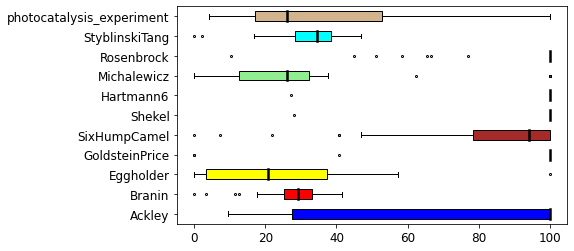

In [15]:
# get the proportion of iterations using predictive model
# 看Predictive model占比
# todo：现在这个代码不对，需要加入50iteration的支持和计算标准差

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

base_dir = r'C:\experiment_results\2022_10_4_14_10_ucb_2.576'

test_problems = [
    'Ackley',
    'Branin',
    'Eggholder',
    'GoldsteinPrice',
    'SixHumpCamel',
    'Shekel',
    'Hartmann6',
    'Michalewicz',
    'Rosenbrock',
    'StyblinskiTang',
    'photocatalysis',
    'swimmer'
]

color_bar = [
    'blue',
    'red',
    'yellow',
    'purple',
    'brown',
    'orange',
    'pink',
    'lightgreen',
    'cyan',
    'aqua',
    'tan',
    'olive',
]

# get predictive model proportion result of one dataframe
def get_result(result_df):
    array = np.array(result_df['Predictive model'])
    array = np.array([eval(i) for i in array])
    array = array.squeeze()
    zero_count = 0
    for i in array:
        if i == 0:
            zero_count += 1
    return 1 - zero_count/len(array)

def plot_all_proportion(base_dir):
    # file_names = [i for i in os.listdir(base_dir) if 'proportion' in i and 'noise' not in i]
    file_names_noise = [i for i in os.listdir(base_dir) if 'proportion' in i and 'noise' in i]
    file_names_noise += [i for i in os.listdir(base_dir) if 'swimmer' in i]
    dfs = {}
    dfs_noise = {}
    for test_problem in test_problems:
        dfs[test_problem] = []
        dfs_noise[test_problem] = []
    for test_problem in test_problems:
        # for file in file_names:
        #     if test_problem in file:
        #         dfs[test_problem].append(get_result(pd.read_csv(os.path.join(base_dir, file), index_col=0)))
        for file in file_names_noise:
            if test_problem in file:
                dfs_noise[test_problem].append(get_result(pd.read_csv(os.path.join(base_dir, file), index_col=0)))
    
    proportion_list = [1.0]
    # std_list = [0.0]
    # box_plot = [[1.0 for i in range(50)]]
    # name_list = ['GP']
    std_list = []
    box_plot = []
    name_list = []
    # for key in dfs.keys():
    #     name_list.append(key)
    #     proportion_list.append(np.mean(dfs[key]))
    #     std_list.append(np.std(dfs[key]))
    #     box_plot.append(dfs[key])
    for key in dfs_noise.keys():
        # name_list.append(key+'_noise')
        name_list.append(key)
        proportion_list.append(np.mean(dfs_noise[key]))
        std_list.append(np.std(dfs_noise[key]))
        l = [i * 100 for i in dfs_noise[key]]
        box_plot.append(l)
    
    plt.figure(figsize=(7, 4))
    boxplot_fig = plt.boxplot(box_plot, labels=name_list, vert=False, patch_artist=True, medianprops=dict(linewidth=2.5, color='black'), 
                             flierprops=dict(markersize=2))
    
    for i, box in enumerate(boxplot_fig['boxes']):
        box.set(facecolor=color_bar[i])
    plt.tick_params(labelsize=12)
    plt.savefig("predictive_model_proportion.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return box_plot
    
box_plot = plot_all_proportion(base_dir)

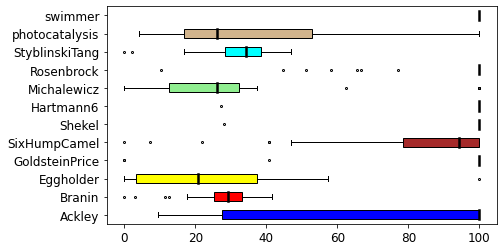

In [1]:
# get the proportion of iterations using predictive model
# 看Predictive model占比
# todo：现在这个代码不对，需要加入50iteration的支持和计算标准差

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

base_dir = r'C:\experiment_results\2022_10_4_14_10_ucb_2.576'

test_problems = [
    'Ackley',
    'Branin',
    'Eggholder',
    'GoldsteinPrice',
    'SixHumpCamel',
    'Shekel',
    'Hartmann6',
    'Michalewicz',
    'Rosenbrock',
    'StyblinskiTang',
    'photocatalysis',
    'swimmer'
]

color_bar = [
    'blue',
    'red',
    'yellow',
    'purple',
    'brown',
    'orange',
    'pink',
    'lightgreen',
    'cyan',
    'aqua',
    'tan',
    'olive',
]

# get predictive model proportion result of one dataframe
def get_result(result_df):
    array = np.array(result_df['Predictive model'])
    array = np.array([eval(i) for i in array])
    array = array.squeeze()
    zero_count = 0
    for i in array:
        if i == 0:
            zero_count += 1
    return 1 - zero_count/len(array)

def plot_all_proportion(base_dir):
    # file_names = [i for i in os.listdir(base_dir) if 'proportion' in i and 'noise' not in i]
    file_names_noise = [i for i in os.listdir(base_dir) if 'proportion' in i and 'noise' in i]
    file_names_noise += [i for i in os.listdir(base_dir) if 'swimmer' in i]
    dfs = {}
    dfs_noise = {}
    for test_problem in test_problems:
        dfs[test_problem] = []
        dfs_noise[test_problem] = []
    for test_problem in test_problems:
        # for file in file_names:
        #     if test_problem in file:
        #         dfs[test_problem].append(get_result(pd.read_csv(os.path.join(base_dir, file), index_col=0)))
        for file in file_names_noise:
            if test_problem in file:
                dfs_noise[test_problem].append(get_result(pd.read_csv(os.path.join(base_dir, file), index_col=0)))
    
    proportion_list = [1.0]
    # std_list = [0.0]
    # box_plot = [[1.0 for i in range(50)]]
    # name_list = ['GP']
    std_list = []
    box_plot = []
    name_list = []
    # for key in dfs.keys():
    #     name_list.append(key)
    #     proportion_list.append(np.mean(dfs[key]))
    #     std_list.append(np.std(dfs[key]))
    #     box_plot.append(dfs[key])
    for key in dfs_noise.keys():
        # name_list.append(key+'_noise')
        name_list.append(key)
        proportion_list.append(np.mean(dfs_noise[key]))
        std_list.append(np.std(dfs_noise[key]))
        l = [i * 100 for i in dfs_noise[key]]
        box_plot.append(l)
    
    plt.figure(figsize=(7, 4))
    boxplot_fig = plt.boxplot(box_plot, labels=name_list, vert=False, patch_artist=True, medianprops=dict(linewidth=2.5, color='black'), 
                             flierprops=dict(markersize=2))
    
    for i, box in enumerate(boxplot_fig['boxes']):
        box.set(facecolor=color_bar[i])
    plt.tick_params(labelsize=12)
    plt.savefig("predictive_model_proportion.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return box_plot
    
box_plot = plot_all_proportion(base_dir)

In [44]:
#  generate results for kappa comparison

df_bo_5 = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_8_24_15_3_ucb_5.152\BO_result_test_photocatalysis_experiment.csv', index_col=0)
df_bo_2 = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results\standardBO_result_test_photocatalysis_experiment.csv', index_col=0)
df_bo_1 = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_8_23_14_33_ucb_1.288\BO_result_test_photocatalysis_experiment.csv', index_col=0)
df_rf = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_8_23_13_18_regression_only_2.576\BO_result_test_photocatalysis_experiment.csv', index_col=0)
df_linear = pd.read_csv(r'C:\Users\darkn\PycharmProjects\SKBO\experiment_results_for_bo_variants\2022_9_1_14_54_ucb_without_mean_2.576_Linear\BO_result_test_photocatalysis_experiment.csv', index_col=0)

problems = ['photocatalysis']
dfs['photocatalysis'] = [df_bo_5, df_bo_2, df_bo_1, df_rf, df_linear]
show_result(dfs, problems, output_file=True, output_file_name='photocatalysis_change_parameter.xlsx')

[{'name': 'BO', 'mean_value_deviation': 0.4725426024827503, 'CMR': 9.382378110431489, 'CMR_deviation': 4.352563024001828, 'median_regret': 6.209278583526611, 'median_regret_deviation': 2.6826877877803286}, {'name': 'BO_noise', 'mean_value_deviation': 0.5754636783345538, 'CMR': 5.521421595982143, 'CMR_deviation': 3.4044487801117786, 'median_regret': 2.216951370239258, 'median_regret_deviation': 1.6938242497095868}, {'name': 'LinearBO', 'mean_value_deviation': 0.8258326151784263, 'CMR': 7.788989623387654, 'CMR_deviation': 5.255148593130032, 'median_regret': 2.391535758972168, 'median_regret_deviation': 2.4237543205803034}, {'name': 'LinearBO_noise', 'mean_value_deviation': 0.1539341346668063, 'CMR': 10.738526312510173, 'CMR_deviation': 0.34950900371064336, 'median_regret': 10.454555034637451, 'median_regret_deviation': 0.1421335250032175}, {'name': 'LinearBOEarlyStop', 'mean_value_deviation': 0.8381359027435665, 'CMR': 6.53079530398051, 'CMR_deviation': 2.6189486030694034, 'median_regret

|   iter    |  target   |    x0     |    x1     |
-------------------------------------------------
|  1        | -21.47    | -19.61    |  28.96    |
|  2        | -17.84    |  10.95    |  4.384    |
|  3        | -20.52    |  16.36    | -5.564    |
|  4        | -21.02    | -17.7     |  9.465    |
|  5        | -19.02    | -20.02    | -6.991    |
|  6        | -21.16    |  23.01    | -29.29    |
|  7        | -21.99    | -31.33    |  3.442    |
|  8        | -16.84    | -5.885    | -10.13    |
|  9        | -20.56    | -0.6904   | -19.24    |
|  10       | -20.67    |  9.153    |  30.14    |
|  11       | -21.01    |  13.05    |  23.67    |
|  12       | -17.99    | -5.126    | -10.46    |
|  13       | -16.04    | -6.065    | -8.888    |
|  14       | -18.25    | -8.396    | -8.849    |
|  15       | -16.1     | -5.339    | -6.705    |
|  16       | -13.95    | -2.644    | -6.144    |
|  17       | -9.66     | -2.098    | -3.974    |
|  18       | -8.513    | -0.39     | -2.642    |


|  101      | -21.28    |  32.69    |  15.95    |
|  102      | -20.1     | -10.29    |  12.62    |
|  103      | -21.91    | -25.5     |  9.571    |
|  104      | -21.49    | -26.76    |  26.78    |
|  105      | -21.78    |  2.372    |  32.77    |


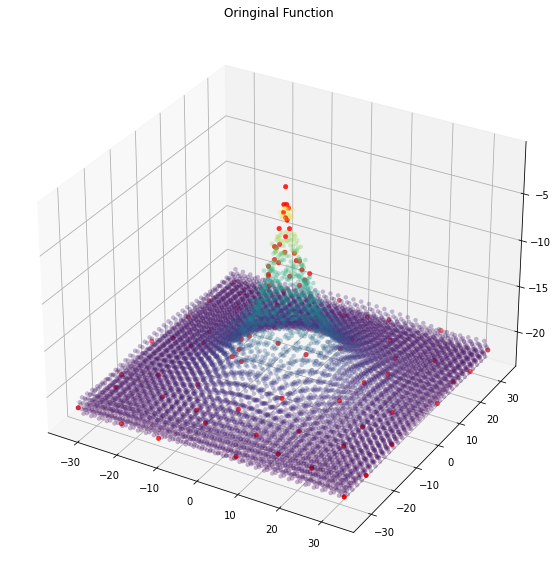

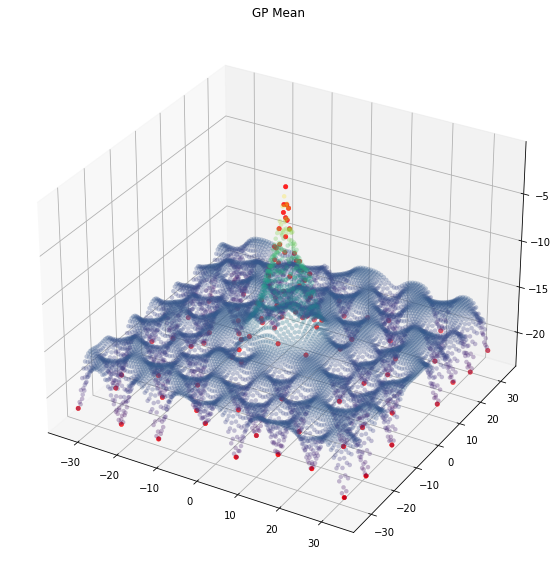

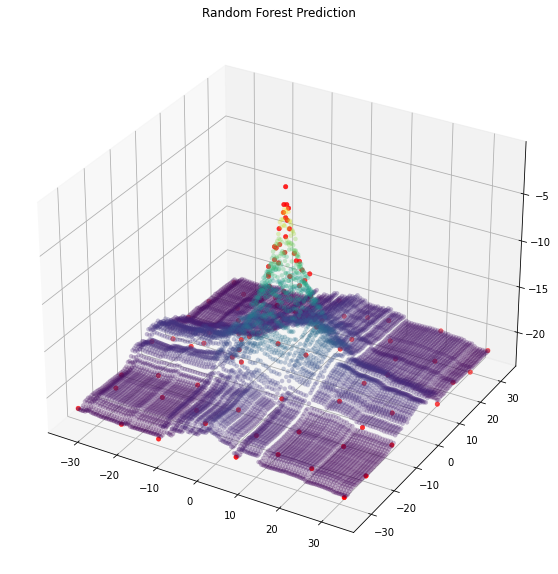

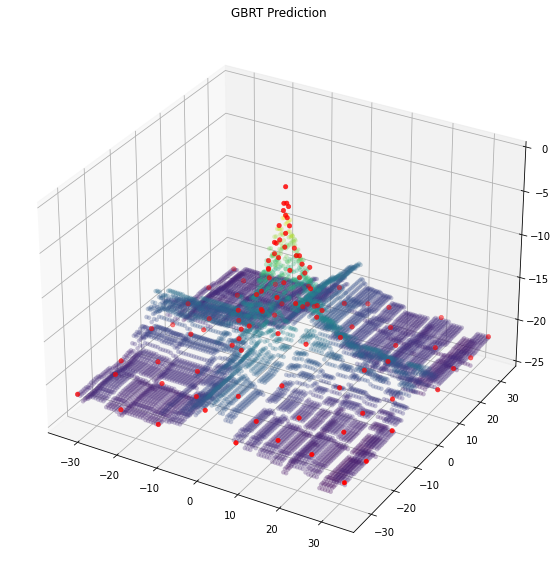

In [3]:
# Show GP prediction less accurate than tree-based models

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from bayes_opt.bayesian_optimization import BayesianOptimization, Queue, TargetSpace
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np


class TestProblem:
    def __init__(self, problem, minimize=False):
        self.problem = problem()
        self.name = self.problem.__class__.__name__
        self.dim = self.problem.dim
        self.input_columns = []
        for i in range(self.dim):
            self.input_columns.append('x'+str(i))
        self.bound = {}
        if isinstance(self.problem.lb, float):
            for i in self.input_columns:
                self.bound[i] = (self.problem.lb, self.problem.ub)
        else:
            for i, input_column in enumerate(self.input_columns):
                self.bound[input_column] = (self.problem.lb[i], self.problem.ub[i])
        self.inverse = -1 if minimize else 1

    def __call__(self, *args, **kwargs):
        # print(args)
        # print(kwargs)
        if args != ():
            return self.problem(*args) * self.inverse
        input_data = list(kwargs.values())
        result = self.problem(input_data)
        if len(result) == 1:
            return self.problem(input_data)[0] * self.inverse
        return self.problem(input_data) * self.inverse


class Ackley:
    """
    Ackley Function
    http://www.sfu.ca/~ssurjano/ackley.html
    """

    def __init__(self, d=2):
        self.dim = d
        self.lb = np.full(self.dim, -32.768)
        self.ub = np.full(self.dim, 32.768)

        # function parameters
        self.a = 20
        self.b = 0.2
        self.c = 2 * np.pi

        # optimum value(s)
        self.xopt = np.full(self.dim, 0.0)
        self.yopt = self.__call__(self.xopt)

        # constraint
        self.cf = None

    def __call__(self, x):
        x = np.atleast_2d(x)

        term1 = -self.a * np.exp(-self.b * np.sqrt(np.mean(np.square(x), axis=1)))
        term2 = -np.exp(np.mean(np.cos(self.c * x), axis=1))

        val = term1 + term2 + self.a + np.exp(1.)

        return val.ravel()


test_problems = [
    Ackley,
]

for problem in test_problems:
    
    test_function = TestProblem(problem, minimize=True)
    optimizer = BayesianOptimization(f=test_function, pbounds=test_function.bound)
    optimizer.maximize(n_iter=100)
    
    x = np.linspace(test_function.bound['x0'][0], test_function.bound['x0'][1], 100)
    y = np.linspace(test_function.bound['x1'][0], test_function.bound['x1'][1], 100)
    grid = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    x = grid.T[0]
    y = grid.T[1]
    
    # print(z.shape)
    # break
    
    save_dir = r'C:\experiment_results\gp regression comparing images'
    import os

    train_x = optimizer.space._params
    train_y = optimizer.space._target

    rf = RandomForestRegressor()
    rf.fit(train_x, train_y)

    gbrt = GradientBoostingRegressor()
    gbrt.fit(train_x, train_y)

    z = test_function(grid)# .reshape(100, 100)
    
    z_gp = optimizer._gp.predict(grid)# .reshape(100, 100)
    z_rf = rf.predict(grid)# .reshape(100, 100)
    z_gbrt = gbrt.predict(grid)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.01, alpha=0.3)
    ax.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    ax.title.set_text('Oringinal Function')
    # plt.savefig(os.path.join(save_dir, test_function.name+'_original.eps'), format='eps')
    plt.show()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z_gp, c=z_gp, cmap='viridis', linewidth=0.01, alpha=0.3)
    ax.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    ax.title.set_text('GP Mean')
    # plt.savefig(os.path.join(save_dir, test_function.name+'_gp_mean.eps'), format='eps')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z_rf, c=z_rf, cmap='viridis', linewidth=0.01, alpha=0.3)
    ax.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    ax.title.set_text('Random Forest Prediction')
    # plt.savefig(os.path.join(save_dir, test_function.name+'_rf.eps'), format='eps')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z_gbrt, c=z_gbrt, cmap='viridis', linewidth=0.01, alpha=0.3)
    ax.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    ax.title.set_text('GBRT Prediction')
    # plt.savefig(os.path.join(save_dir, test_function.name+'_gbrt.eps'), format='eps')

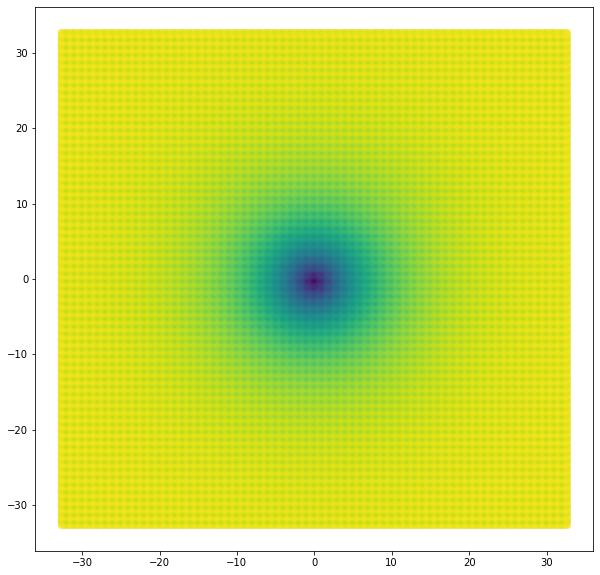

In [18]:
x = np.linspace(test_function.bound['x0'][0], test_function.bound['x0'][1], 500)
y = np.linspace(test_function.bound['x1'][0], test_function.bound['x1'][1], 500)
grid = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
x = grid.T[0]
y = grid.T[1]
z = -test_function(grid)# .reshape(100, 100)

fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(x, y, c=z, cmap='viridis', linewidth=0.01, alpha=0.3)
plt.show()

|   iter    |  target   |    x0     |    x1     |
-------------------------------------------------
|  1        | -21.25    |  22.94    |  21.34    |
|  2        | -19.05    | -7.873    |  11.58    |
|  3        | -21.32    |  20.23    | -24.21    |
|  4        | -21.97    | -30.73    | -28.65    |
|  5        | -21.22    |  26.37    |  3.89     |
|  6        | -19.42    | -8.154    |  12.42    |
|  7        | -18.77    | -9.28     |  8.465    |
|  8        | -15.09    | -3.583    |  7.018    |
|  9        | -10.85    |  1.267    |  4.199    |
|  10       | -11.75    |  3.676    | -3.2      |
|  11       | -17.2     |  8.593    |  4.65     |
|  12       | -10.35    | -2.737    | -2.593    |
|  13       | -18.66    | -4.364    | -13.0     |
|  14       | -2.023    | -0.0512   |  0.277    |
|  15       | -5.476    | -2.025    |  0.9831   |
|  16       | -6.784    |  2.001    |  0.5356   |
|  17       | -20.27    | -31.97    |  31.89    |
|  18       | -5.871    |  0.3794   | -1.371    |


|  101      | -6.215    | -1.013    | -2.149    |
|  102      | -7.014    | -1.281    |  1.807    |
|  103      | -16.18    | -2.175    | -8.502    |
|  104      | -15.97    |  9.174    |  0.2434   |
|  105      | -21.4     | -25.38    |  5.206    |


C:\Users\darkn\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\darkn\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\darkn\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\darkn\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\darkn\anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


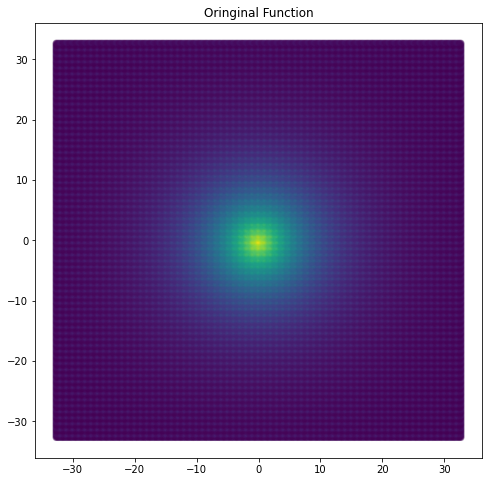

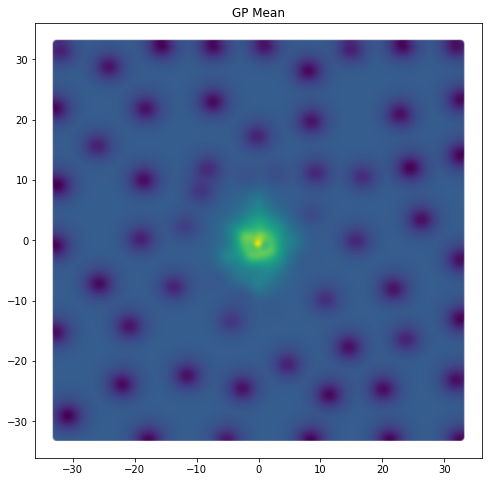

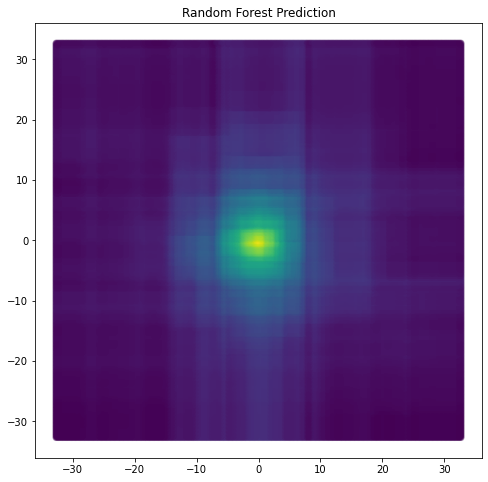

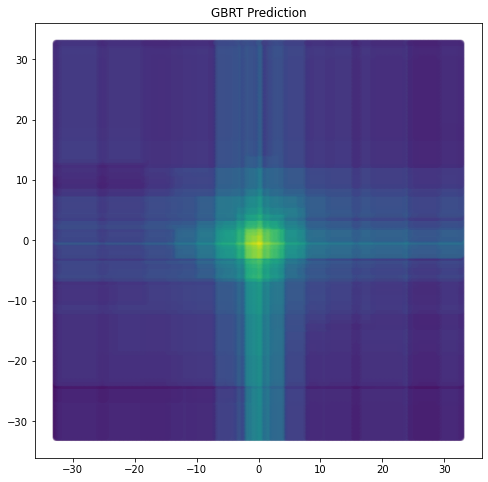

In [24]:
# Show GP prediction less accurate than tree-based models

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from bayes_opt.bayesian_optimization import BayesianOptimization, Queue, TargetSpace
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np


class TestProblem:
    def __init__(self, problem, minimize=False):
        self.problem = problem()
        self.name = self.problem.__class__.__name__
        self.dim = self.problem.dim
        self.input_columns = []
        for i in range(self.dim):
            self.input_columns.append('x'+str(i))
        self.bound = {}
        if isinstance(self.problem.lb, float):
            for i in self.input_columns:
                self.bound[i] = (self.problem.lb, self.problem.ub)
        else:
            for i, input_column in enumerate(self.input_columns):
                self.bound[input_column] = (self.problem.lb[i], self.problem.ub[i])
        self.inverse = -1 if minimize else 1

    def __call__(self, *args, **kwargs):
        # print(args)
        # print(kwargs)
        if args != ():
            return self.problem(*args) * self.inverse
        input_data = list(kwargs.values())
        result = self.problem(input_data)
        if len(result) == 1:
            return self.problem(input_data)[0] * self.inverse
        return self.problem(input_data) * self.inverse


class Ackley:
    """
    Ackley Function
    http://www.sfu.ca/~ssurjano/ackley.html
    """

    def __init__(self, d=2):
        self.dim = d
        self.lb = np.full(self.dim, -32.768)
        self.ub = np.full(self.dim, 32.768)

        # function parameters
        self.a = 20
        self.b = 0.2
        self.c = 2 * np.pi

        # optimum value(s)
        self.xopt = np.full(self.dim, 0.0)
        self.yopt = self.__call__(self.xopt)

        # constraint
        self.cf = None

    def __call__(self, x):
        x = np.atleast_2d(x)

        term1 = -self.a * np.exp(-self.b * np.sqrt(np.mean(np.square(x), axis=1)))
        term2 = -np.exp(np.mean(np.cos(self.c * x), axis=1))

        val = term1 + term2 + self.a + np.exp(1.)

        return val.ravel()


test_problems = [
    Ackley,
]

for problem in test_problems:
    
    test_function = TestProblem(problem, minimize=True)
    optimizer = BayesianOptimization(f=test_function, pbounds=test_function.bound)
    optimizer.maximize(n_iter=100)
    
    x = np.linspace(test_function.bound['x0'][0], test_function.bound['x0'][1], 500)
    y = np.linspace(test_function.bound['x1'][0], test_function.bound['x1'][1], 500)
    grid = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    x = grid.T[0]
    y = grid.T[1]
    
    # print(z.shape)
    # break
    
    save_dir = r'C:'
    import os

    train_x = optimizer.space._params
    train_y = optimizer.space._target

    rf = RandomForestRegressor()
    rf.fit(train_x, train_y)

    gbrt = GradientBoostingRegressor()
    gbrt.fit(train_x, train_y)

    z = test_function(grid)# .reshape(100, 100)
    
    z_gp = optimizer._gp.predict(grid)# .reshape(100, 100)
    z_rf = rf.predict(grid)# .reshape(100, 100)
    z_gbrt = gbrt.predict(grid)
    
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=z, cmap='viridis', linewidth=0.01, alpha=0.3)
    plt.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    plt.title('Oringinal Function')
    plt.savefig(test_function.name+'_original.pdf', format='pdf', dpi=500)

    fig = plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=z_gp, cmap='viridis', linewidth=0.01, alpha=0.3)
    plt.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    plt.title('GP Mean')
    plt.savefig(test_function.name+'_gp_mean.pdf', format='pdf', dpi=500)

    fig = plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=z_rf, cmap='viridis', linewidth=0.01, alpha=0.3)
    plt.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    plt.title('Random Forest Prediction')
    plt.savefig(test_function.name+'_rf.pdf', format='pdf', dpi=500)

    fig = plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=z_gbrt, cmap='viridis', linewidth=0.01, alpha=0.3)
    plt.scatter(train_x.T[0], train_x.T[1], train_y, c='red', linewidth=0.5)
    plt.title('GBRT Prediction')
    plt.savefig(test_function.name+'_gbrt.pdf', format='pdf', dpi=500)